# LAB 01: MỐI QUAN HỆ CỦA DỮ LIỆU

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from datetime import datetime
import geopandas as gpd
import warnings
from mpl_toolkits.axes_grid1 import make_axes_locatable

np.set_printoptions(formatter=dict(float='{:0.2f}'.format))
plt.style.use('ggplot')


## 1. Thông tin nhóm

| MSSV     | HỌ VÀ TÊN          |
|:--------:|:-------------------|
| 20127323 | Võ Nhật Tân        |
| 20127447 | Ngô Đức Bảo        |
| 20127275 | Lê Nguyễn Nhật Phú |
| 20127681 | Nguyễn Thiên Phúc  |


## 2. Lấy thông tin từ website

In [2]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from datetime import datetime, timedelta
from bs4 import BeautifulSoup

In [3]:
def pre_process_html(table_html):
    table_html = table_html.replace('>N/A<', '>-<')
    
    table = BeautifulSoup(table_html)

    def show_data_continent(tag):
        if tag.name == 'th':
            return True
        
        return 'data-continent' in tag.attrs and tag.name in ['td', 'th'] and tag['data-continent'] != ""

    for k, th in enumerate(table.find_all(show_data_continent)):
        raw_s = th.text
        th['style'] = "color: yellow"


    for k, th in enumerate(table.find_all('th')):
        th.string = th.text

    return table.prettify()

In [4]:
driver = webdriver.Chrome()
driver.maximize_window()

driver.get("https://www.worldometers.info/coronavirus/#main_table")
WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, "main_table_countries_today")))

#Get updated date
updated_date = driver.find_element(By.CSS_SELECTOR, 'div#page-top+div')
today = datetime.strptime(updated_date.text, "Last updated: %B %d, %Y, %H:%M %Z")

#Get today data
table_element_today = driver.find_element(By.ID, 'main_table_countries_today')
table_html_today = table_element_today.get_attribute('outerHTML')

#Get yesterday data
driver.find_element(By.ID, 'nav-yesterday-tab').click()
table_element_yesterday = driver.find_element(By.ID, 'main_table_countries_yesterday')
table_html_yesterday = table_element_yesterday.get_attribute('outerHTML')

#Get 2-day ago data
driver.find_element(By.ID, 'nav-yesterday2-tab').click()
table_element_yesterday = driver.find_element(By.ID, 'main_table_countries_yesterday2')
table_html_yesterday2 = table_element_yesterday.get_attribute('outerHTML')

driver.quit()

ProtocolError: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))

In [ ]:
# Save all collected data to raw_data folder
table_html = pre_process_html('\n'.join([table_html_today, table_html_yesterday, table_html_yesterday2]))
df_list = pd.read_html(table_html, keep_default_na=False)

for day in range(3):
    exp_day = today - timedelta(days=day)
    df_list[day]['DateCollected'] = exp_day.strftime("%d-%m-%Y")
    df_list[day].to_csv(f'./raw_data/{exp_day.strftime("%d-%m-%Y")+"_raw"}.csv', index=False, encoding='UTF-8')

## Tiền xử lý dữ liệu

* Các việc cần làm để tiền xử lý dữ liệu
    - Chuẩn hóa tên cột
    - Xóa cột Serious,Critical (dữ liệu chỉ thể hiện số bệnh nhân điều trị ở Intensive Care Unit (ICU), nếu có báo cáo. Vì vậy, nhóm quyết định không quan tâm đến cột này)
    - Tiền xử lý các giá trị thiếu, giá trị lỗi
    - Kiểm tra kiểu dữ liệu mỗi cột
    - Kiểm tra tính chính xác của một số cột
    - Lưu thành file sau khi tiền xử lý

In [ ]:
def pre_process_file(file_path):
    df = pd.read_csv(file_path)

    #Rename the abnormal column's name
    df.rename(columns={'Tot\xa0Cases/1M pop': 'Tot Cases/1M pop'}, inplace=True)

    #Drop the unnecessary columns
    df.drop(columns=['#', 'Serious,Critical'], inplace=True)

    #Drop the total row
    df = df.drop(labels=[len(df) - 1]).reset_index(drop=True)
    
    #Fill the null values and negative values with 0 and replace the NA (-) values by np.nan
    df.fillna(0, inplace=True)
    df._get_numeric_data()[df._get_numeric_data() < 0] = 0
    df.replace(to_replace='-', value=np.nan, inplace=True)

    #Change the type of columns
    columns_name = df.select_dtypes(include='object').columns
    for column_name in columns_name:
        if column_name in ['Country,Other', 'Continent', 'DateCollected'] : continue
        df[column_name] = df[column_name].astype('float')

    #Check if the data has inconsistent values
    sub_df = df.iloc[1:-1, :]

    cal_tot = round(sub_df['TotalCases'] / sub_df['Population'] * 10**6).replace([np.inf, -np.inf], 0)
    cal_deaths = round(sub_df['TotalDeaths'] / sub_df['Population'] * 10**6).replace([np.inf, -np.inf], 0)

    if not np.all(sub_df['Tot Cases/1M pop'] == cal_tot):
        raise Exception(f"Data in the Tot Cases/ 1M pop column is not consistent")
    
    if not np.all(sub_df['Deaths/1M pop'] == cal_deaths):
        raise Exception(f"Data in the Total Deaths column is not consistent")

    return df

In [ ]:
#Apply the preprocess to all the file in raw_data and save them to data folder
files = [f for f in listdir('./raw_data/')]
col = []
countries = []


for file in files:
    url = './raw_data/' + file

    df = pre_process_file(url)
    if len(col) == 0 or len(countries) == 0: 
        if len(col) == 0: col = list(df.columns)
        if len(countries) == 0: countries = df['Country,Other'].unique().tolist()
    else:
        if col != list(df.columns):
            warnings.warn(url, ': File is not the same structure')

        diff_contries = list(set(countries) - set(df['Country,Other'].unique().tolist()))
        if len(diff_contries) != 0:
            warnings.warn(f"{url}: this dataset does not contains to some countries: {', '.join(diff_contries)}")

    df.to_csv('./data/' + file.replace('_raw', ''), index=False, encoding='UTF-8')

* Các file sau khi tiền xử lý có chung một cấu trúc 
* Các file có cùng tên và số lượng quốc gia tham gia khảo sát

## Thông tin về dữ liệu

- Mỗi file là thông tin tình hình dịch bệnh Covid-19 trên từng quốc gia theo từng ngày.
- Trong mỗi file có tổng cộng 13 cột:

| Tên thuộc tính   | Ý nghĩa                                                             |
|------------------|---------------------------------------------------------------------|
| Country,Other    | Quốc gia, khác                                                      |
| TotalCases       | Tổng số ca nhiễm đã được ghi nhận                                   |
| NewCases         | Tổng số ca nhiễm mới trong ngày                                     |
| TotalDeaths      | Tổng số ca nhiễm chết người đã được ghi nhận                        |
| NewDeaths        | Tổng số ca nhiễm chết người mới trong ngày                          |
| TotalRecovered   | Tổng số ca nhiễm đã hồi phục đã được ghi nhận                       |
| NewRecovered     | Tổng số ca nhiễm đã hồi phục mới trong ngày                         |
| ActiveCases      | Tổng số ca đang phát hiện bị nhiễm virus                            |
| Tot Cases/1M pop | Tổng số ca nhiễm đã được ghi nhận trên một triệu dân số             |
| Deaths/1M pop    | Tổng số ca nhiễm chết người đã được ghi nhận trên một triệu dân số  |
| TotalTests       | Tổng số lần xét nghiệm (kiểm tra) nhiễm virus                       |
| Tests/ 1M pop    | Tổng số lần xét nghiệm (kiểm tra) nhiễm virus trên một triệu dân số |
| Population       | Dân số của một quốc gia, khác                                       |
| Continent        | Châu lục                                                            |
| DateCollected    | Ngày thu thập thông tin                                             |

## Trực quan hóa dữ liệu

In [6]:
def concatinate_data(list_file_name, folder_path = './data/'):
    df = pd.DataFrame()

    for file_name in list_file_name:
        df_cat = pd.read_csv(folder_path + file_name)
        df_cat['DateCollected'] = pd.to_datetime(df_cat['DateCollected'], dayfirst=True)
        df = pd.concat([df, df_cat], axis=0)

    df = df.reset_index()
    df = df.drop(columns={'index'})
    return df

In [7]:
from os import listdir

files = [datetime.strptime(f.replace('.csv', ''), '%d-%m-%Y') for f in listdir('./data/')]

three_newest_days = sorted(files)
df = concatinate_data(map(lambda date: date.strftime("%d-%m-%Y") + '.csv', three_newest_days))

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3016 entries, 0 to 3015
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Country,Other     3016 non-null   object        
 1   TotalCases        3016 non-null   int64         
 2   NewCases          3016 non-null   float64       
 3   TotalDeaths       3016 non-null   float64       
 4   NewDeaths         3016 non-null   float64       
 5   TotalRecovered    2769 non-null   float64       
 6   NewRecovered      2769 non-null   float64       
 7   ActiveCases       2769 non-null   float64       
 8   Tot Cases/1M pop  3016 non-null   float64       
 9   Deaths/1M pop     3016 non-null   float64       
 10  TotalTests        3016 non-null   float64       
 11  Tests/ 1M pop     3016 non-null   float64       
 12  Population        3016 non-null   float64       
 13  Continent         3016 non-null   object        
 14  DateCollected     3016 n

### Thế giới

In [9]:
world_data = df[df['Country,Other'] == 'World']
world_data.head(10)

,"Country,Other",TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/ 1M pop,Population,Continent,DateCollected
0,World,679742243,75340.0,6798879.0,296.0,652512495.0,104956.0,20430869.0,87205.0,872.2,0.0,0.0,0.0,All,2023-02-26
232,World,679865129,112273.0,6799716.0,705.0,652669816.0,157321.0,20395597.0,87220.0,872.3,0.0,0.0,0.0,All,2023-02-27
464,World,680068046,128801.0,6801130.0,655.0,652820630.0,149957.0,20446286.0,87246.0,872.5,0.0,0.0,0.0,All,2023-02-28
696,World,680261711,143685.0,6802334.0,767.0,653004808.0,173193.0,20454569.0,87271.0,872.7,0.0,0.0,0.0,All,2023-03-01
928,World,680435562,116376.0,6804035.0,722.0,653196665.0,141028.0,20434862.0,87294.0,872.9,0.0,0.0,0.0,All,2023-03-02
1160,World,680538320,102750.0,6804666.0,621.0,653342308.0,145115.0,20391346.0,87307.0,873.0,0.0,0.0,0.0,All,2023-03-03
1392,World,680626732,81870.0,6805021.0,345.0,653456905.0,108525.0,20364806.0,87318.0,873.0,0.0,0.0,0.0,All,2023-03-04
1624,World,680700273,61029.0,6805512.0,292.0,653526300.0,69375.0,20368461.0,87327.0,873.1,0.0,0.0,0.0,All,2023-03-05
1856,World,680788906,64785.0,6806351.0,552.0,653647296.0,117898.0,20335259.0,87339.0,873.2,0.0,0.0,0.0,All,2023-03-06
2088,World,680968133,100234.0,6807855.0,551.0,653825902.0,177791.0,20334376.0,87362.0,873.4,0.0,0.0,0.0,All,2023-03-07


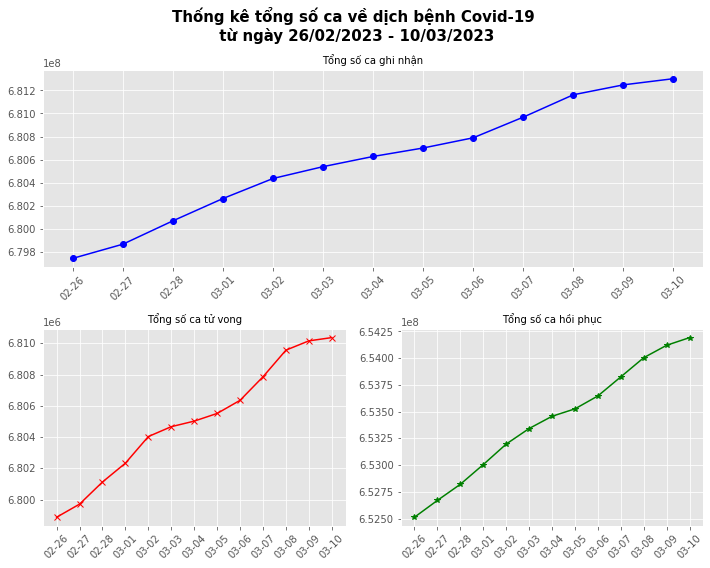

In [34]:

fig = plt.figure()
gs = fig.add_gridspec(2,2)
fig.set_figheight(8)
fig.set_figwidth(10)


ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

ax1.plot(world_data['DateCollected'], world_data['TotalCases'], color='blue', marker='o',)
ax2.plot(world_data['DateCollected'], world_data['TotalDeaths'], color='red', marker='x')
ax3.plot(world_data['DateCollected'], world_data['TotalRecovered'], color='green', marker='*')

for ax in [ax1, ax2, ax3]:
    labels = world_data['DateCollected'].dt.strftime('%m-%d')

    ax.set_ylim(bottom=None)
    ax.set_xticks(world_data['DateCollected'], labels, rotation=45)

ax1.set_title('Tổng số ca ghi nhận', fontsize=10)
ax2.set_title('Tổng số ca tử vong',  fontsize=10)
ax3.set_title('Tổng số ca hồi phục', fontsize=10)

min_dt, max_dt = world_data['DateCollected'].min(), world_data['DateCollected'].max()
fig.suptitle(f'Thống kê tổng số ca về dịch bệnh Covid-19 \n từ ngày {min_dt.strftime("%d/%m/%Y")} - {max_dt.strftime("%d/%m/%Y")} ', fontsize=15, fontweight="bold")
fig.tight_layout()

**Nhận xét:** 
- Nhìn chung tốc độ tăng trưởng các ca trên toàn thế giới đang có xu hướng chậm lại, nguyên nhân do tổng số ca tử vong và tổng số ca hồi phục tăng tương đối nhanh

### Châu lục

In [11]:
countries_df = df[(df['Country,Other'] != 'World') & (df['Continent'] != '0')]
continent_df = countries_df.groupby(['DateCollected', 'Continent']).sum(numeric_only =True).reset_index(level=[0, 1])
continent_df['Tot Cases/1M pop'] = continent_df['TotalCases'] / continent_df['Population'] * 10**6
continent_df['Deaths/1M pop'] = continent_df['TotalDeaths'] / continent_df['Population'] * 10**6
continent_df['TotalRecovered/1M pop'] = continent_df['TotalRecovered'] / continent_df['Population'] * 10**6
continent_df

,DateCollected,Continent,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/ 1M pop,Population,TotalRecovered/1M pop
0,2023-02-26,Africa,12792192,766.0,258577.0,1.0,10956539.0,26.0,364186.0,9093.574049,183.814400,1.103003e+08,10896465.0,1.406729e+09,7788.665048
1,2023-02-26,Asia,214254266,36094.0,1536304.0,146.0,182087172.0,55400.0,13472303.0,45476.128400,326.085260,2.373277e+09,92821011.0,4.711357e+09,38648.563543
2,2023-02-26,Australia/Oceania,13994994,1301.0,26110.0,5.0,13776098.0,1190.0,67445.0,321943.010059,600.638485,8.855240e+07,20810364.0,4.347041e+07,316907.492564
3,2023-02-26,Europe,246170589,26377.0,2016458.0,69.0,241656057.0,27649.0,2216782.0,329305.890592,2697.444484,2.823573e+09,212828842.0,7.475438e+08,323266.737065
4,2023-02-26,North America,124553800,6734.0,1610998.0,47.0,119602007.0,17285.0,2438122.0,208234.876880,2693.341915,1.303705e+09,101363029.0,5.981409e+08,199956.237403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,2023-03-10,Asia,214668984,29348.0,1538211.0,132.0,182486348.0,21160.0,13485930.0,45564.153573,326.490026,2.376263e+09,92880978.0,4.711357e+09,38733.289879
74,2023-03-10,Australia/Oceania,14027545,0.0,26221.0,0.0,13804466.0,0.0,71143.0,322691.818305,603.191946,8.855310e+07,20811137.0,4.347041e+07,317560.074430
75,2023-03-10,Europe,246823583,20484.0,2021632.0,59.0,242278751.0,47221.0,2241770.0,330179.409933,2704.365818,2.824760e+09,212938789.0,7.475438e+08,324099.723666
76,2023-03-10,North America,124908631,3809.0,1614587.0,18.0,120125666.0,3764.0,2264978.0,208828.099966,2699.342173,1.305629e+09,101419429.0,5.981409e+08,200831.715047


<AxesSubplot:>

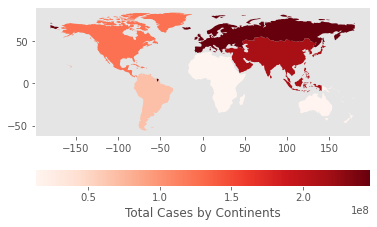

In [12]:
filter_continent_df = continent_df[continent_df['DateCollected'] == continent_df['DateCollected'].max()].copy()
filter_continent_df.loc[filter_continent_df['Continent'] == 'Australia/Oceania', 'Continent'] = 'Oceania'

df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df_world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")).drop(['gdp_md_est'], axis=1)
df_world = df_world.dissolve(by='continent', aggfunc='sum' )
df_world.index.name = 'Continent'

df_world = df_world.merge(filter_continent_df, how='left', on='Continent')

fig, ax = plt.subplots(1, 1)
ax.grid(False)

df_world.plot(column='TotalCases', cmap='Reds', figsize=30, legend=True, ax=ax,
              legend_kwds={'label': "Total Cases by Continents", 'orientation': "horizontal"})

**Nhận xét**:
- Tổng số trường hợp nhiễm ghi nhận ở châu Âu và Châu Á chiếm đa số 
- Châu Đại Dương và châu Phi cũng ghi nhận số ca ít nhất.

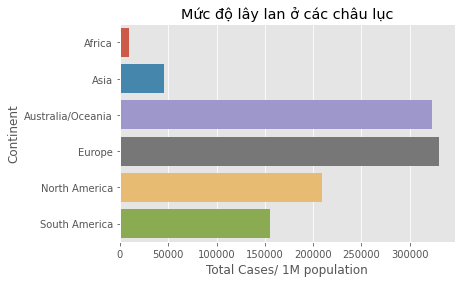

In [13]:
filter_continent_df = continent_df[continent_df['DateCollected'] == continent_df['DateCollected'].max()]
ax = sns.barplot(x='Tot Cases/1M pop', y='Continent', data=filter_continent_df)
ax.set(xlabel='Total Cases/ 1M population', ylabel='Continent', title='Mức độ lây lan ở các châu lục');


***Nhận xét**:
- Tốc độ lây lan ở Châu Phi và Châu Đại Dương rất nhanh trong khi ở châu Phi ghi nhận khá chậm

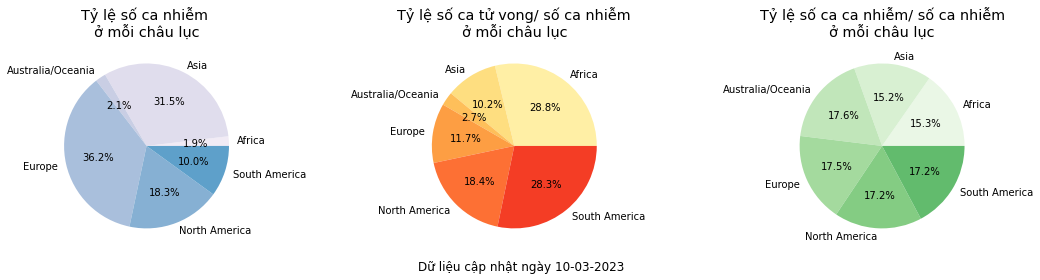

In [14]:
filter_continent_df = continent_df.loc[continent_df['DateCollected'] == continent_df['DateCollected'].max(), :]

fig, axes = plt.subplots(1, 3)
gs = fig.add_gridspec(2,2)
fig.set_figheight(4)
fig.set_figwidth(15)

axes[0].pie(filter_continent_df['TotalCases'], labels=filter_continent_df['Continent'], autopct='%1.1f%%', colors=sns.color_palette('PuBu', n_colors=10));
axes[1].pie(filter_continent_df['TotalDeaths'] / filter_continent_df['TotalCases'], labels=filter_continent_df['Continent'], autopct='%1.1f%%', colors=sns.color_palette('YlOrRd', n_colors=8));
axes[2].pie(filter_continent_df['TotalRecovered'] / filter_continent_df['TotalCases'], labels=filter_continent_df['Continent'], autopct='%1.1f%%', colors=sns.color_palette('Greens', n_colors=10));

axes[1:]

axes[0].set_title('Tỷ lệ số ca nhiễm \nở mỗi châu lục')
axes[1].set_title('Tỷ lệ số ca tử vong/ số ca nhiễm\nở mỗi châu lục')
axes[2].set_title('Tỷ lệ số ca ca nhiễm/ số ca nhiễm\nở mỗi châu lục')

date_updated = continent_df['DateCollected'].max().strftime('%d-%m-%Y')

fig.suptitle(f'Dữ liệu cập nhật ngày {date_updated}', y=0)
fig.tight_layout()

**Nhận xét**:
- Châu đại dương chiếm 2.1% tổng số ca nhiễm trong đó tỷ lệ ca hồi phục khoảng 17.6%, tỷ lệ tử vong khoảng 2.7%, tương tự đối với Châu Phi. Điều này cho thấy các nước ở Châu đại dương, Châu Phi có tỉ lệ hồi phục cao.
- Các quốc gia khác đang cho thấy sự tăng tỷ lệ số ca tử vong, đặc biệt là Nam Mỹ khi tổng số ca chỉ chiếm 10% nhưng tỷ lệ tử vong chiếm đến 28.3% tổng số ca tử vong trong khi số ca phục hồi chỉ đạt 17.2%. 

### Quốc gia

#### Tình hình dịch bệnh ở các quốc gia từ ngày 26/02/2023 như thế nào?

Để xem xét tình hình dịch bệnh ở các quốc gia hiện nay, ta có thể đặt 1 số câu hỏi như: 
* Các ca tử vong mới, các ca nhiễm mới và các ca hồi phục mới những ngày gần đây như thế nào ở các quốc gia?
* Độ tương quan của các ca nhiễm mới, các ca tử vong mới và các ca hồi phục mới ở các quốc gia này như thế nào?
* Những quốc gia nào có tỷ lệ xét nghiệm cao nhất và điều này liên quan gì đến số lượng người nhiễm bệnh và số lượng tử vong của họ?

In [15]:
files = [f for f in listdir('./data/')]

df_dict = {}

for file in files:
    url = './data/' + file
    df_dict[file[:-4]] = pd.read_csv(url)

In [16]:
country_list = list(df_dict.values())[0].sort_values(by=['TotalCases'], ascending=False).iloc[:6]['Country,Other'].to_list()
country_list.remove('World')

##### Các ca tử vong mới, các ca nhiễm mới và các ca hồi phục mới những ngày gần đây như thế nào ở các quốc gia?

Bằng cách xem xét các ca tử vong mới, các ca nhiễm mới và các ca hồi phục mới, chúng ta có thể thấy tình hình đại dịch ở các quốc gia trong những ngày gần đây.

In [17]:
date_list = []
new_death = []
new_cases = []
new_recovered = []
for key, item in df_dict.items():
    date_list.append(key)
    temp = item.set_index('Country,Other')
    new_death.append(temp['NewDeaths'][country_list].to_list())
    new_cases.append(temp['NewCases'][country_list].to_list())
    new_recovered.append(temp['NewRecovered'][country_list].to_list())

new_death_df = pd.DataFrame(new_death, columns=country_list, index=date_list)
new_cases_df = pd.DataFrame(new_cases, columns=country_list, index=date_list)
new_recovered_df = pd.DataFrame(new_recovered, columns=country_list, index=date_list)

new_death_df.index = pd.to_datetime(new_death_df.index, format='%d-%m-%Y')
new_cases_df.index = pd.to_datetime(new_cases_df.index, format='%d-%m-%Y')
new_recovered_df.index = pd.to_datetime(new_recovered_df.index, format='%d-%m-%Y')

new_death_df = new_death_df.sort_index()
new_cases_df = new_cases_df.sort_index()
new_recovered_df = new_recovered_df.sort_index()

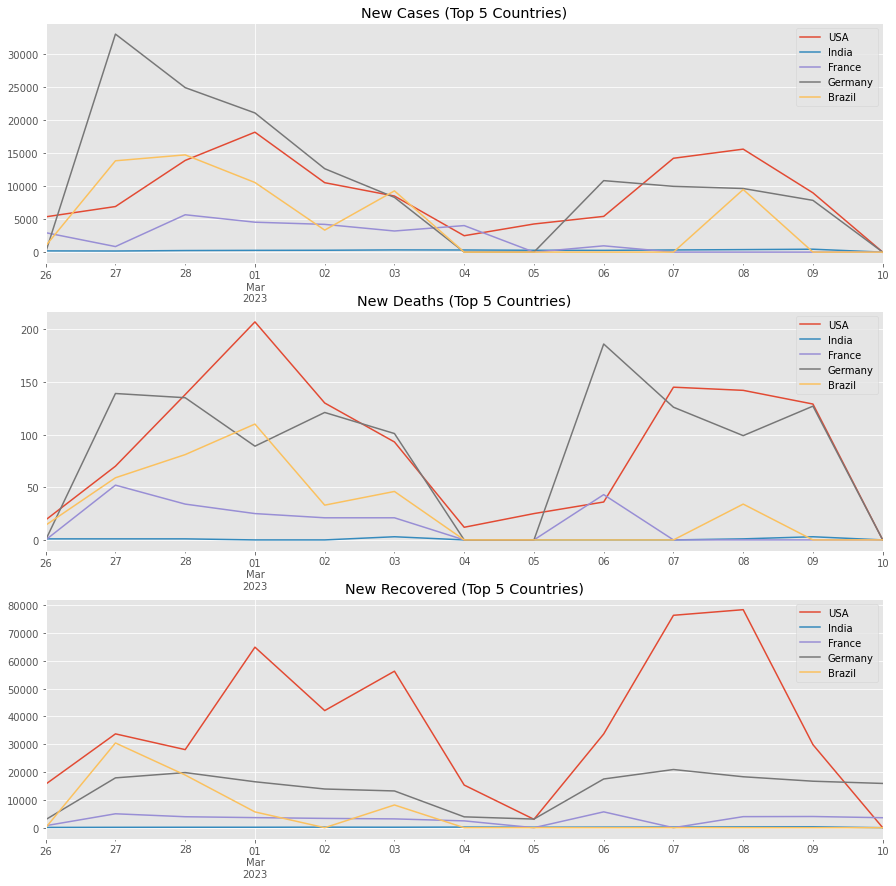

In [18]:
#visualize 3 charts in one figure
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
new_cases_df.plot(ax=ax[0], title='New Cases (Top 5 Countries)')
new_death_df.plot(ax=ax[1], title='New Deaths (Top 5 Countries)')
new_recovered_df.plot(ax=ax[2], title='New Recovered (Top 5 Countries)')
plt.show()

* Từ biểu đồ, có thể thấy đại dịch vẫn đang lan rộng trên thế giới, nhưng đã có một số tín hiệu đáng mừng. Các ca mắc mới và tử vong mới đang giảm và duy trì ở mức thấp, trong khi các ca phục hồi mới đang gia tăng và ổn định ở các quốc gia có nhiều ca nhiễm nhất.
* Trong khi đó, tại Mỹ và Đức những ngày qua số ca mắc mới và tử vong có sự gia tăng đáng kể.
* Mỹ cho thấy họ có Hệ thống chăm sóc y tế tốt vì số ca mắc mới khỏi bệnh luôn cao hơn số ca mắc mới và số ca tử vong.

##### Độ tương quan của các ca nhiễm mới, các ca tử vong mới và các ca hồi phục mới ở các quốc gia này như thế nào?

Trả lời câu hỏi này sẽ giúp chúng ta phần nào hiểu được tình hình đại dịch ở các quốc gia, nếu độ tương quan giữa các ca nhiễm mới và các ca tử vong cao và độ tương quan giữa các ca nhiễm mới và các ca bình phục thấp thì có nghĩa là kế hoạch chống dịch của quốc gia đó không tốt, và ngược lại.

In [19]:
#find the sum of new cases, new death, new recovered of each country
total_new_death = []
total_new_cases = []
total_new_recovered = []
for country in country_list:
    total_new_death.append(new_death_df[country].sum())
    total_new_cases.append(new_cases_df[country].sum())
    total_new_recovered.append(new_recovered_df[country].sum())

#convert to dataframe
total_new_death_df = pd.DataFrame(total_new_death, index=country_list, columns=['Total New Death'])
total_new_cases_df = pd.DataFrame(total_new_cases, index=country_list, columns=['Total New Cases'])
total_new_recovered_df = pd.DataFrame(total_new_recovered, index=country_list, columns=['Total New Recovered'])

#concat all the dataframe
corr_df = pd.concat([total_new_death_df, total_new_cases_df, total_new_recovered_df], axis=1)

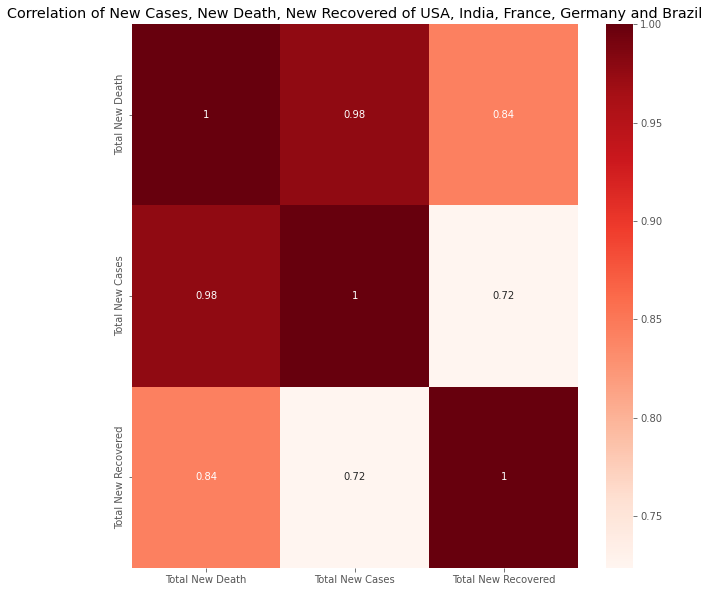

In [20]:
#visualize the correlation using heatmap
plt.figure(figsize=(10,10))
sns.heatmap(corr_df.corr(), annot=True, cmap='Reds')
plt.title('Correlation of New Cases, New Death, New Recovered of USA, India, France, Germany and Brazil')
plt.show()

Từ biểu đồ ta có thể thấy rằng độ tương quan giữa các ca nhiễm mới và các ca tử vong mới cao, trong khi độ tương quan giữa các ca nhiễm mới và các ca hồi phục mới thấp. Điều này cho thấy rằng các quốc gia này đang có kế hoạch chống dịch không tốt trong khoảng thời gian từ ngày 26/2/2023 đến nay.

##### Những quốc gia nào có tỷ lệ xét nghiệm cao nhất và điều này liên quan gì đến số lượng người nhiễm bệnh và số lượng tử vong của họ?

Trả lời câu hỏi này sẽ cho ta biết sự ứng phó với đại dịch covid-19 của các quốc gia.

In [21]:
country_list = list(df_dict.values())[0].sort_values(by=['TotalCases'], ascending=False)['Country,Other'].to_list()
country_list.remove('World')
date_objs = [datetime.strptime(date, '%d-%m-%Y') for date in df_dict.keys()]
latest_date = max(date_objs)
latest_date_str = latest_date.strftime('%d-%m-%Y')

In [22]:
total_tests = []
total_cases = []
total_deaths = []
for country in country_list:
    total_cases.append(df_dict[latest_date_str].set_index('Country,Other')['TotalCases'][country])
    total_tests.append(df_dict[latest_date_str].set_index('Country,Other')['TotalTests'][country])
    total_deaths.append(df_dict[latest_date_str].set_index('Country,Other')['TotalDeaths'][country])

total_tests_df = pd.DataFrame(total_tests, index=country_list, columns=['total_tests'])
total_cases_df = pd.DataFrame(total_cases, index=country_list, columns=['total_cases'])
total_death_df = pd.DataFrame(total_deaths, index=country_list, columns=['total_deaths'])

total_tests_df = total_tests_df.sort_index()
total_cases_df = total_cases_df.sort_index()
total_death_df = total_death_df.sort_index()

test_percent_df = pd.concat([total_tests_df, total_cases_df, total_death_df], axis=1)
#compute the test percentage compared to the total test in the world
test_percent_df['test_percentage'] = test_percent_df['total_tests']/test_percent_df['total_tests'].sum()*100
test_percent_df = test_percent_df.sort_values(by=['test_percentage'], ascending=False)

<AxesSubplot:title={'center':'Top 20 countries having the highest test percentage'}>

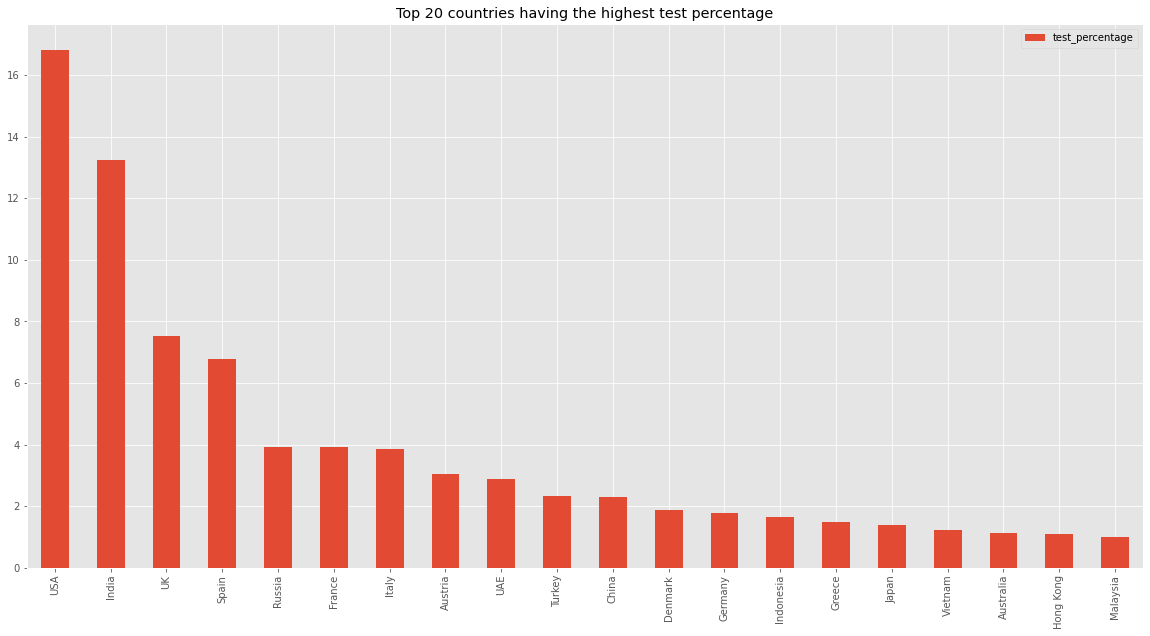

In [23]:
test_percent_df.head(20).plot(kind='bar', y='test_percentage', figsize=(20,10), title='Top 20 countries having the highest test percentage', grid=True)

Như ta có thể thấy từ biểu đồ, đây là 20 quốc gia có tỉ lệ xét nghiệm cao nhất (trong đó có Việt Nam). \
Vậy, con số ca nhiễm và tử vong của các quốc gia này mối tương quan như thế nào?

Text(0.5, 1.0, 'Total Tests vs Total Cases')

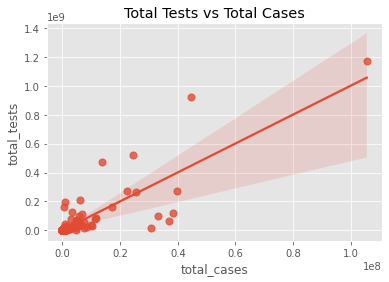

In [24]:
sns.regplot(x='total_cases', y='total_tests', data=test_percent_df, scatter_kws={"s": 50})
plt.title('Total Tests vs Total Cases')

Text(0.5, 1.0, 'Total Tests vs Total Deaths')

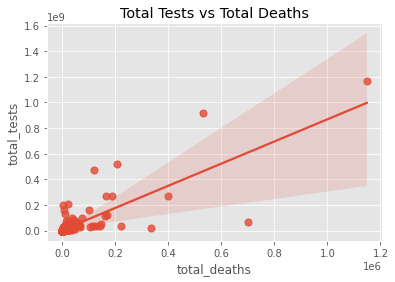

In [25]:
sns.regplot(x='total_deaths', y='total_tests', data=test_percent_df, scatter_kws={"s": 50})
plt.title('Total Tests vs Total Deaths')

Như ta có thể thấy, ở biểu đồ tương quan giữa số ca mắc và số ca test, khi số test tăng thì số ca nhiễm cũng tăng. \
Ngược lại, khi số test tăng thì số ca tử vong chỉ nằm ở mức thấp (0-0.2).  

<AxesSubplot:>

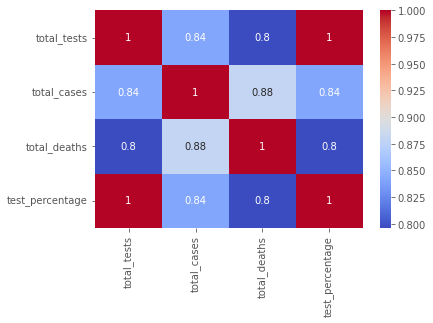

In [26]:
sns.heatmap(test_percent_df.corr(), annot=True, cmap='coolwarm')

Từ những biểu đồ trên, ta có thể kết luận rằng các quốc gia có tỉ lệ xét nghiệm cao thì có thể phát hiện được nhiều ca nhiễm hơn, nhưng số ca tử vong lại thấp hơn. Điều này có nghĩa là khi các ca mắc được phát hiện sớm, họ có thể được điều trị kịp thời và có tỉ lệ sống sót cao hơn.

#### Tình hình dịch bệnh Covid-19 trên 5 quốc gia có tỉ lệ ca tử vong cao nhất tại thời điểm mới nhất

In [27]:
final_df = df.drop(df[df['Country,Other'] == 'World'].index).reset_index(drop=True)
top_5_countries_death = final_df.sort_values('Deaths/1M pop', ascending=False)['Country,Other'].unique()[:5]
top_5_countries_death_df = final_df[final_df['Country,Other'].isin(top_5_countries_death)].reset_index(drop=True)

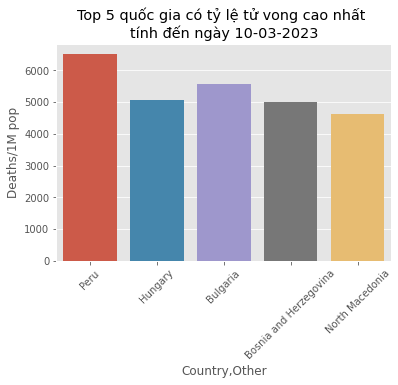

In [28]:
newest_day = top_5_countries_death_df["DateCollected"].max()
fiter_top_5_countries_death_df = top_5_countries_death_df.loc[top_5_countries_death_df["DateCollected"] == newest_day, ['Country,Other', 'Deaths/1M pop']]

fig = sns.barplot(data=fiter_top_5_countries_death_df, x='Country,Other', y='Deaths/1M pop')
fig.set_xticklabels(fig.get_xticklabels(), rotation=45);
fig.set_title(f"Top 5 quốc gia có tỷ lệ tử vong cao nhất \ntính đến ngày {newest_day.strftime('%d-%m-%Y')}");

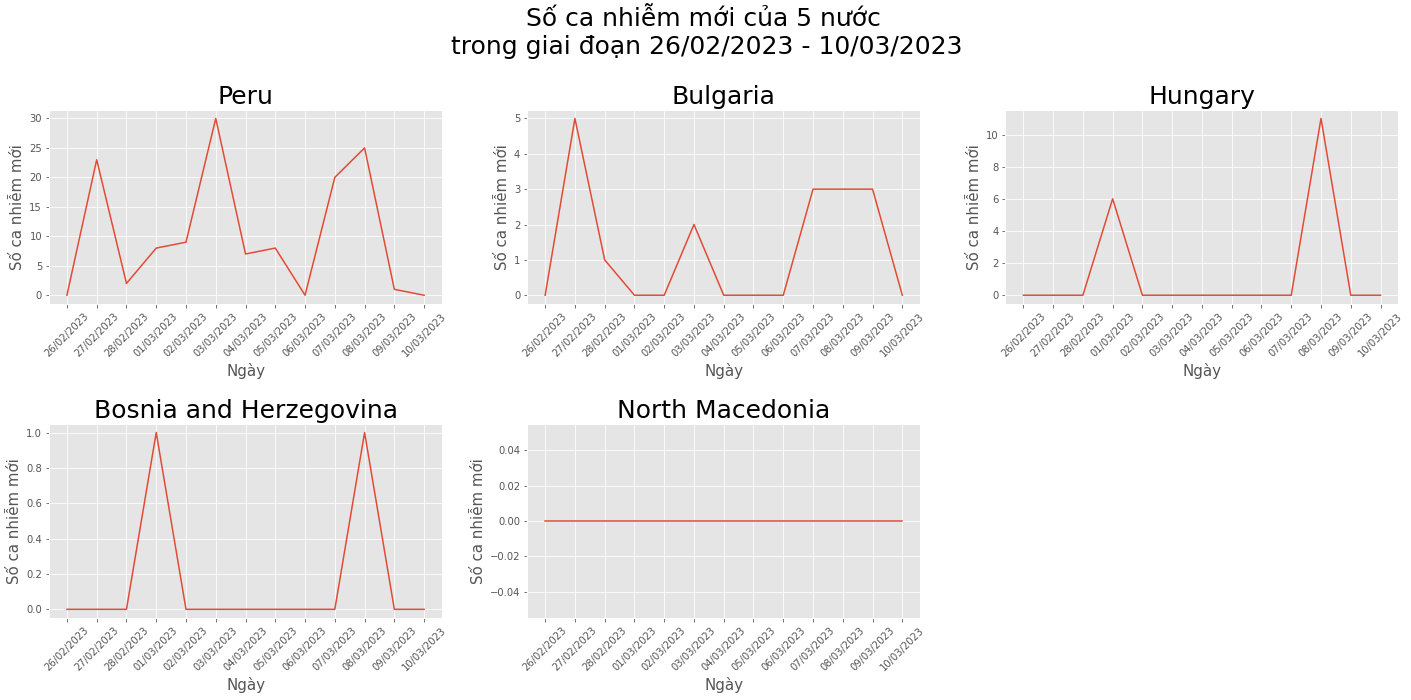

In [29]:
new_cases_df = top_5_countries_death_df.copy()
new_cases_df['NewCasesPerCapital'] = new_cases_df['NewCases'] / new_cases_df['Population'] * 1000000
new_cases_df = new_cases_df.groupby(['Country,Other', 'DateCollected']).sum(numeric_only=True)

#draw line chart for each country
fig, axes = plt.subplots(2, 3, figsize=(20,10))
axes = axes.flatten()

for i, country in enumerate(top_5_countries_death):
    ax = axes[i]
    sns.lineplot(data=new_cases_df.loc[country], x='DateCollected', y='NewDeaths', legend=True, ax=ax)
    ax.set_title(f'{country}', size=25)
    ax.set_ylabel('Số ca nhiễm mới', size = 15)
    ax.set_xlabel('Ngày', size = 15)
    ax.set_xticks(new_cases_df.loc[country].index, new_cases_df.loc[country].index.to_series().dt.strftime('%d/%m/%Y') ,rotation=45)

        
oldest_day = top_5_countries_death_df["DateCollected"].min()
newest_day = top_5_countries_death_df["DateCollected"].max()

plt.suptitle(f"Số ca nhiễm mới của 5 nước \ntrong giai đoạn {oldest_day.strftime('%d/%m/%Y')} - {newest_day.strftime('%d/%m/%Y')}", size=25);
fig.delaxes(axes[2*3-1])
fig.tight_layout(pad=2)

**Nhận xét**

- Số ca nhiễm mới của 2 nước Peru và Bulgaria biến động khá lớn, trong khi đó nước North Macedonia không ghi nhận thêm ca nhiễm mới nào

- Nước Hungary có số ca nhiễm mới đạt đỉnh điểm vào 2 ngày 1/3/2023 và 8/3/2023, khu vực Bosnia and Herzegovina có số ca nhiễm mới đạt đỉnh điểm vào 2 ngày 28/2/2023 và 8/3/2023

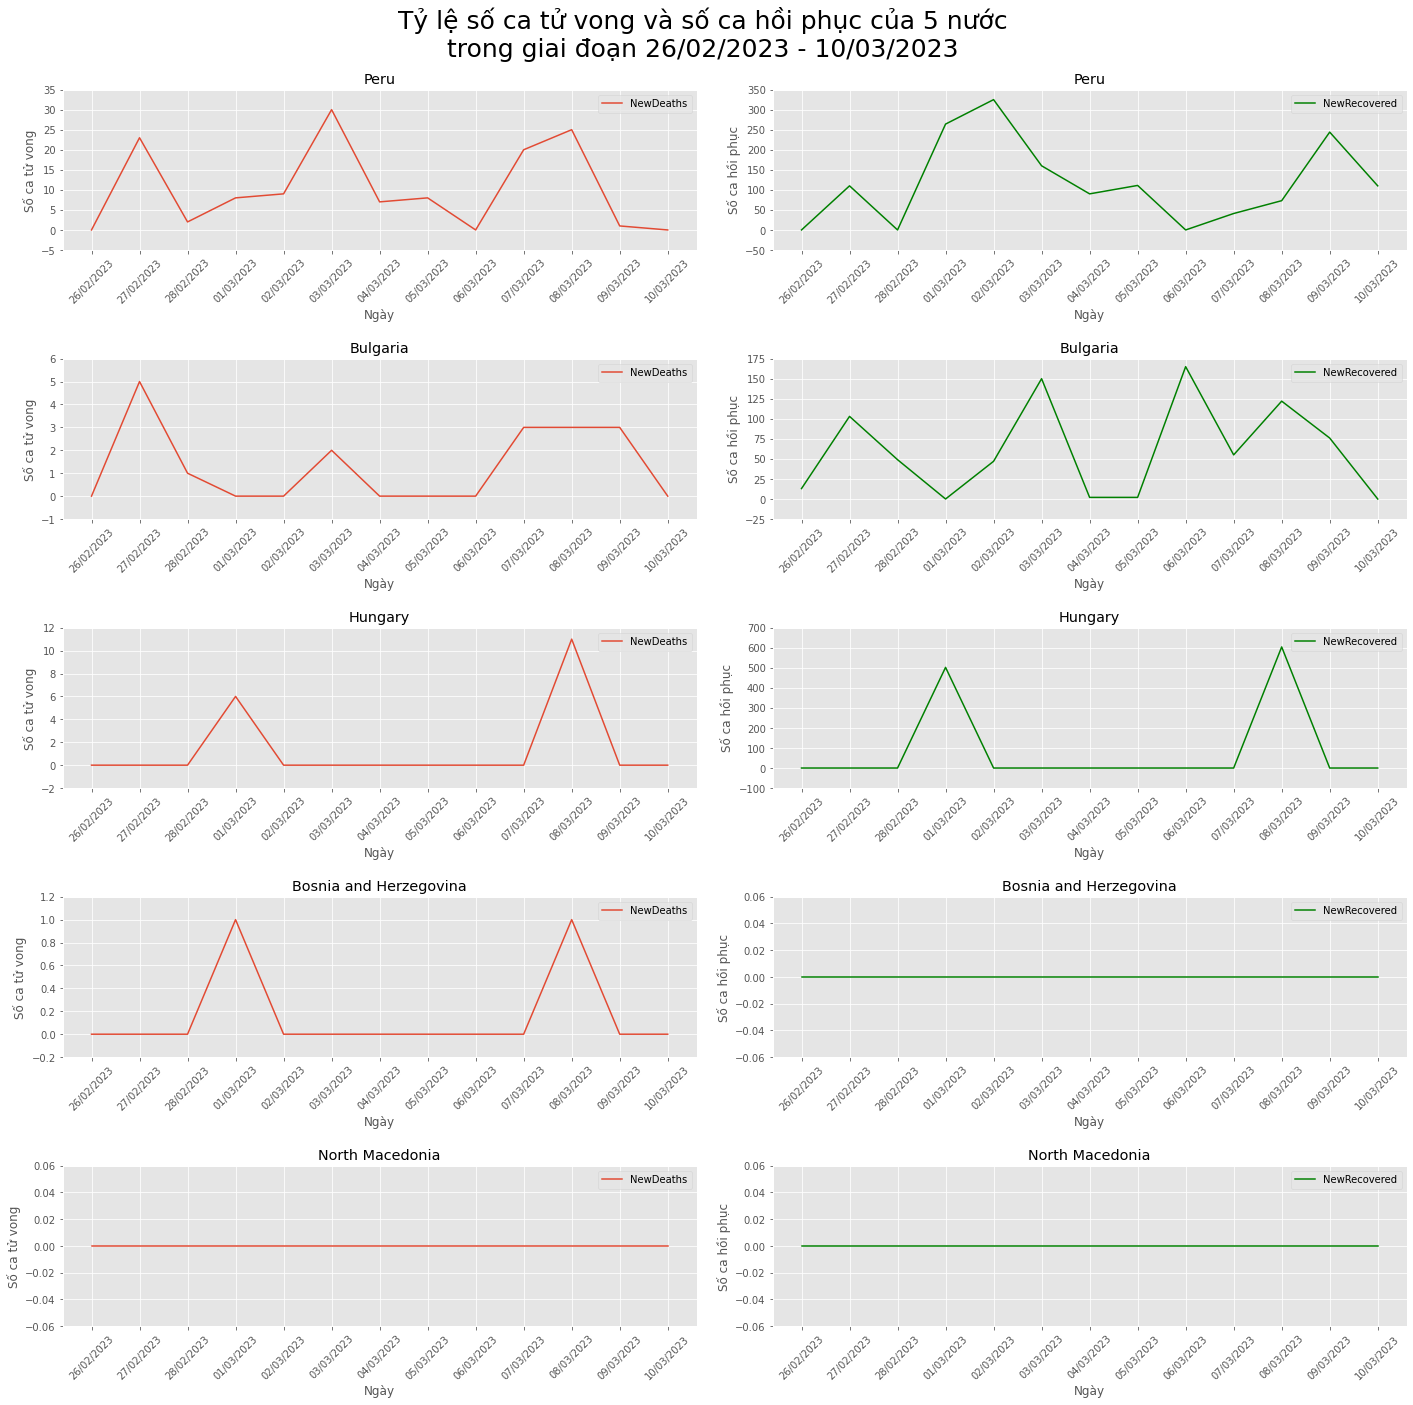

In [30]:
trend_top_5_countries_death_df = top_5_countries_death_df.groupby(['Country,Other', 'DateCollected']).sum(numeric_only=True)
fig, axes = plt.subplots(5, 2, figsize=(20,20))

for i, country in enumerate(top_5_countries_death):
    sns.lineplot(data=trend_top_5_countries_death_df.loc[country], x='DateCollected', y='NewDeaths', legend=True, ax=axes[i, 0])
    sns.lineplot(data=trend_top_5_countries_death_df.loc[country], x='DateCollected', y='NewRecovered', ax=axes[i, 1], legend=True, color='g')
    axes[i, 0].set_title(f'{country}')
    axes[i, 0].set_ylabel('Số ca tử vong')
    axes[i, 0].set_xlabel('Ngày')
    axes[i, 0].set_yticks(axes[i, 0].get_yticks())
    axes[i, 0].set_xticks(trend_top_5_countries_death_df.loc[country].index, trend_top_5_countries_death_df.loc[country].index.to_series().dt.strftime('%d/%m/%Y') ,rotation=45)
    axes[i, 0].legend(['NewDeaths'])

    axes[i, 1].set_ylabel('Số ca hồi phục')
    axes[i, 1].set_title(f'{country}')
    axes[i, 1].set_xlabel('Ngày')
    axes[i, 1].set_yticks(axes[i, 1].get_yticks())
    axes[i, 1].set_xticks(trend_top_5_countries_death_df.loc[country].index, trend_top_5_countries_death_df.loc[country].index.to_series().dt.strftime('%d/%m/%Y') ,rotation=45)
    axes[i, 1].legend(['NewRecovered'])

oldest_day = top_5_countries_death_df["DateCollected"].min()
newest_day = top_5_countries_death_df["DateCollected"].max()

fig.suptitle(f"Tỷ lệ số ca tử vong và số ca hồi phục của 5 nước \ntrong giai đoạn {oldest_day.strftime('%d/%m/%Y')} - {newest_day.strftime('%d/%m/%Y')} ", size=25)
fig.tight_layout(pad=2)

**Nhận xét**

- Nhìn chung, số ca tử vong của 5 nước có tỉ lệ tử vong cao nhất có xu hướng giảm 

- Về số ca tử vong mới, 2 nước Peru và Bulgaria có số ca tử vong mới biến động khá lớn và đạt giá trị khá cao so với các nước còn lại. Trong khi đó North Macedonia không ghi nhận thêm ca tử vong mới nào. Nước Hungary và khu vực Bosnia và Herzegovina có số ca tử vong mới đạt đỉnh điểm vào 2 ngày 1/3/2023 và 8/3/2023

- Về số ca hồi phục mới, 2 nước Peru và Bulgaria cũng có số ca hồi phục mới biến động mạnh và đạt giá trị khá cao so với các nước còn lại. Trong khi đó North Macedonia và khu vực Bosnia và Herzegovina không ghi nhận thêm ca hồi phục mới nào. Nước Hungary có số ca hồi phục mới đạt đỉnh điểm vào 2 ngày 1/3/2023 và 8/3/2023


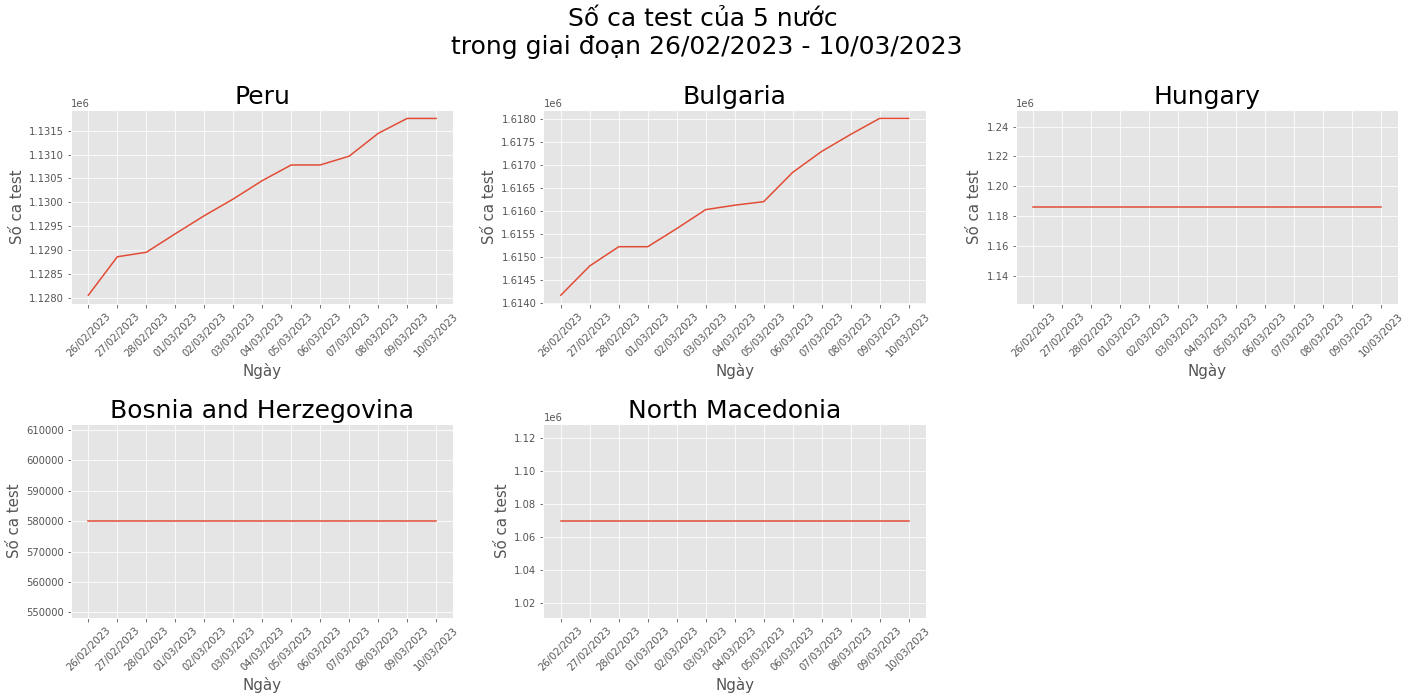

In [31]:
test_situations_df = top_5_countries_death_df.groupby(['Country,Other', 'DateCollected']).sum(numeric_only=True)
test_situations_df = test_situations_df.loc[top_5_countries_death, ['Tests/ 1M pop']]
fig, axes = plt.subplots(2, 3, figsize=(20,10))
axes = axes.flatten()

for i, country in enumerate(top_5_countries_death):
    ax = axes[i]
    sns.lineplot(data=test_situations_df.loc[country], x='DateCollected', y='Tests/ 1M pop', legend=True, ax=ax)
    ax.set_title(f'{country}', size=25)
    ax.set_ylabel('Số ca test', size = 15)
    ax.set_xlabel('Ngày', size = 15)
    ax.set_xticks(test_situations_df.loc[country].index, test_situations_df.loc[country].index.to_series().dt.strftime('%d/%m/%Y') ,rotation=45)

        
oldest_day = top_5_countries_death_df["DateCollected"].min()
newest_day = top_5_countries_death_df["DateCollected"].max()

plt.suptitle(f"Số ca test của 5 nước \ntrong giai đoạn {oldest_day.strftime('%d/%m/%Y')} - {newest_day.strftime('%d/%m/%Y')}", size=25);
fig.delaxes(axes[2*3-1])
fig.tight_layout(pad=2)

**Nhận xét**

- Vì số ca tử vong ở nước Peru biến động mạnh và đạt giá trị cao, do đó chính phủ đã tăng cường kiểm soát dịch bệnh bằng việc thực hiện việc test, từ biểu đồ cho thấy số ca test tăng mạnh, cao nhất là 1,13 tỷ ca/ngày. Bên cạnh đó, nước Bulgaria cũng có tỷ lệ thực hiện test khá cao

- Ngoài ra, tỷ lệ ca test ở các nước Hungary, Bosnia and Herzegovina, North Macedonia cũng đạt mức cao nhưng không tăng dần theo thời gian


**Nhận xét chung**
- Từ biểu đồ tỷ lệ số ca hồi phục và số ca tử vong, ta thấy nước Hungary có số ca tử vong mới đạt đỉnh điểm vào 2 ngày 1/3/2023 và ngày 8/3/2023, và trong 2 ngày này, số ca hồi phục ở quốc gia này cũng đạt đỉnh điểm, điều đó cho thấy công tác phòng chống dịch tại Hungary được tăng cường mạnh vào 2 mốc thời gian này
- Cũng vào mốc thời gian này, số ca tử vong ở khu vực Bosnia and Herzegovina cũng tăng đột biến, nhưng số ca hồi phục lại không được ghi nhận thêm
- Tại quốc gia Peru, số ca nhiễm mới và số ca tử vong đồng thời tăng đột biến vào ngày 3/3/2023 cho thấy tình hình dịch bệnh ở quốc gia này đang diễn biến phức tạp vào thời gian này